# Machine Learning Project: Key Detection
Authors: Zach Hayes, Matt Gaetano, Max Ivry

Course: CS3540


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

### Gather Training and Testing Data
Data cleaning and feature extraction occured earlier in process. See clean.ipynb

In [2]:
def retrieve_data():
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }
    
        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    return train_test_split(train_df.drop(columns=['target']), train_df["target"], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
all_keys = y_train.unique()

C:\Users\Zachary\AppData\Local\Temp\ipykernel_20848\3188777155.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  train_df = pd.read_json("train.json", lines=True)
C:\Users\Zachary\AppData\Local\Temp\ipykernel_20848\3188777155.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  train_df = pd.read_json("train.json", lines=True)
C:\Users\Zachary\AppData\Local\Temp\ipykernel_20848\3188777155.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprec

### Visualization: PCA

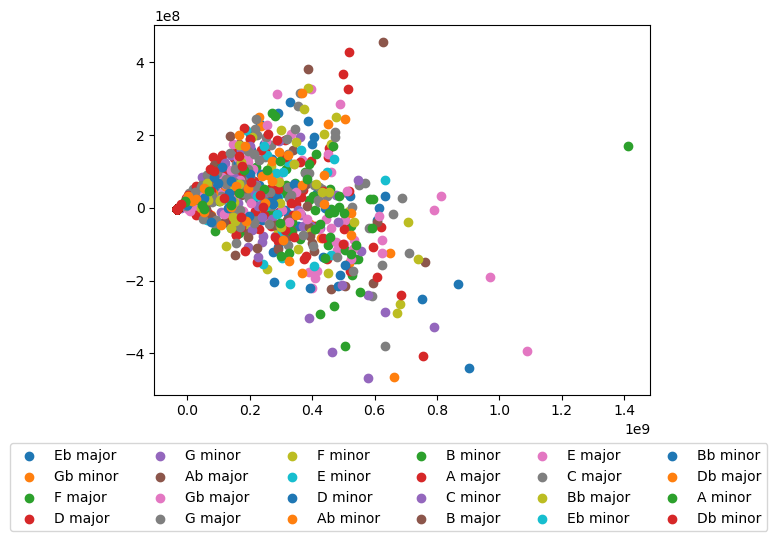

In [3]:
# PCA for initial visualization
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data, columns=["x", "y"])
transformed_df = transformed_df.join(y_train)

fig = plt.figure()
ax = fig.add_subplot()
for key in all_keys:
  samples = transformed_df[transformed_df["target"] == key]
  ax.scatter(x=samples["x"], y=samples["y"], label=key)
plt.legend(loc='right', bbox_to_anchor=(1.25, -0.25), ncol=6)

### Machine Learning Approach 1:
### Logistic Regression Full Key Classification

In [9]:
log_reg = LogisticRegression()

# Use grid search to find the best regularization for the data
param_grid = {
    'C': [1, 10, 1000, 10000]
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

log_reg = LogisticRegression(C=best_params["C"])
log_reg.fit(X_train, y_train)
log_reg_results = log_reg.predict(X_test)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_results)
conf_matrix_to_df(conf_matrix, all_keys)

c:\Users\Zachary\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zachary\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_re

,Eb major,Gb minor,F major,D major,G minor,Ab major,Gb major,G major,F minor,E minor,...,C minor,B major,E major,C major,Bb major,Eb minor,Bb minor,Db major,A minor,Db minor
Eb major,98,4,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,0,3
Gb minor,2,79,0,3,0,0,0,0,5,0,...,1,3,0,0,0,0,3,1,0,0
F major,0,0,48,4,0,0,0,2,0,0,...,0,0,2,3,0,4,0,0,2,0
D major,0,0,1,42,4,0,0,0,0,0,...,0,1,0,1,0,0,0,0,2,0
G minor,0,0,0,0,76,2,0,0,0,0,...,5,0,0,0,0,0,0,0,6,1
Ab major,2,0,0,0,10,29,0,0,0,0,...,1,8,0,0,0,0,1,0,0,0
Gb major,0,0,0,0,1,0,90,0,0,1,...,0,0,5,0,9,0,0,7,0,0
G major,0,0,0,0,0,0,2,39,0,1,...,0,0,1,0,1,2,0,0,0,0
F minor,0,2,0,0,0,0,0,0,119,2,...,0,0,0,0,8,0,6,3,0,0
E minor,0,0,0,0,0,0,6,1,2,52,...,0,0,7,0,2,1,0,8,0,0


Text(0.5, 1.0, 'Confusion Matrix Heat Map')

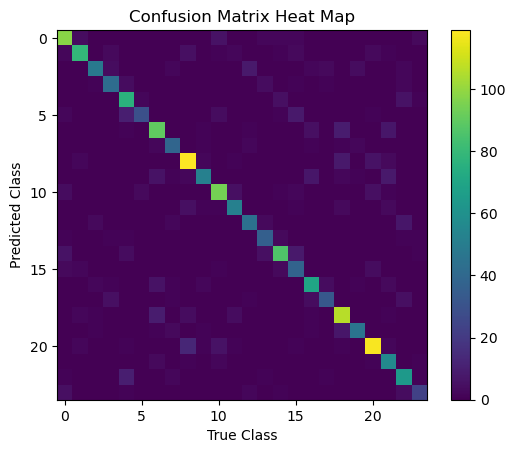

In [10]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

In [11]:
print(classification_report(y_true=y_test, y_pred=log_reg_results))

              precision    recall  f1-score   support

     A major       0.80      0.84      0.82       117
     A minor       0.87      0.79      0.83       100
    Ab major       0.86      0.66      0.74        73
    Ab minor       0.75      0.76      0.76        55
     B major       0.70      0.84      0.77        90
     B minor       0.85      0.53      0.65        55
    Bb major       0.77      0.79      0.78       114
    Bb minor       0.76      0.81      0.79        48
     C major       0.80      0.84      0.82       141
     C minor       0.85      0.66      0.74        79
     D major       0.82      0.82      0.82       115
     D minor       0.80      0.79      0.79        66
    Db major       0.76      0.75      0.75        59
    Db minor       0.71      0.82      0.76        44
     E major       0.83      0.78      0.81       110
     E minor       0.59      0.75      0.66        51
    Eb major       0.77      0.78      0.77        90
    Eb minor       0.79    

### Machine Learning Approach 2:
### SVM Modality Classification

In [3]:
# Transform the target to modality only
def convert_to_modality(x):
    return x.split()[1]

y_train_mode = y_train.apply(convert_to_modality)
y_test_mode = y_test.apply(convert_to_modality)

#transform y into binary array 
label_encoder = LabelEncoder()
y_train_mode = label_encoder.fit_transform(y_train_mode)
y_test_mode = label_encoder.fit_transform(y_test_mode)


In [8]:
# Create an SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale', C=75000)
svm_classifier.fit(X_train, y_train_mode)

y_pred_mode = svm_classifier.predict(X_test)
target_names = label_encoder.classes_

In [9]:
def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test_mode, y_pred=y_pred_mode)
conf_matrix_to_df(conf_matrix, target_names)

,major,minor
major,1152,111
minor,655,52


In [11]:
print(classification_report(y_test_mode, y_pred_mode, target_names=target_names))

              precision    recall  f1-score   support

       major       0.64      0.91      0.75      1263
       minor       0.32      0.07      0.12       707

    accuracy                           0.61      1970
   macro avg       0.48      0.49      0.44      1970
weighted avg       0.52      0.61      0.52      1970

